# 2022 IIEP/UNESCO Hackathon - ClaraVista submission

Welcome to the Claravista team submission for the second challenge of the 2022 edition of the **IIEP/Unesco Hackathon**. This notebook comes in a fully documented deposit and we invite you to read its `README.md` file for more information about the challenge.

This notebook represents the Python part of the submission, i.e. the automated computations taking the DEM and school coordinates data as input, the sea level rise parameters and produces a list of the flooded schools per year as well as the required visualization.

The data used by this notebook is contained in the `data` folder of this deposit. This folder contains the following data:
- `dem.tif`: DEM of a small patch of land in Bangladesh,
- `schools.geojson`: coordinates of schools in Bengladesh.

If you wish to use this notebook to perform the computations on different data (corresponding to different parts of the world), you must change the path parameters in the "Parameters" section below. The remainder of this notebook is fully automated and links to the parameters defined in this section.

Enjoy, and we hope this notebook will help !
The ClaraVista team
(Antoine INZA, Victor BELLAIGUE, Ahmed-Amine HOMMAN)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import rasterio as rio
import json

from osgeo import gdal
from os.path import join

## Parameters

This section contains the parameters of the notebook. If you wish to use this notebook on another land patch than the one provided in this deposit, this is where you should change things. The remaining sections automatically links to the below parameters and should not need any change.

### I/O & data parameters

In the cell below, you should put the paths towards the two files required for this notebook:
- `DEM_PATH`: the path towards the DEM file, in GeoTIFF format, of the considered region.
- `SCHOOLS_PATH`: the path towards the school coordinates file, in *geojson* or *json* format, inside the considered region.

You must also specify the paths towards the output folder (`OUTPUT_FOLDER` variable) where this *notebook* will export its results. If the output folder does not exist, *this notebook will create it*.


In [2]:
DEM_PATH = join("data", "dem.tif")
SCHOOLS_PATH = join("data", "schools.geojson")
OUTPUT_FOLDER = "output"

We then have to define the sea level rise parameters. These will allow to compute the sea level elevation for each year and therefore the corresponding flooded schools.

In [3]:
CURRENT_YEAR = 2020
CURRENT_ELEVATION = 0.0
TARGET_YEAR = 2050
TARGET_ELEVATION = 10.0  # we take a very large predicted elevation for this example

## Processing

We now perform the necessary computations & transformations in order to obtain the flooded school list per year.

### Data Importation

We start by loading the data using the paths provided in the parameter section.

In [4]:
raster = gdal.Open(DEM_PATH)  # loading of the DEM data

# load school coordinates in pandas.DataFrame
with open(SCHOOLS_PATH, "r", encoding="utf8") as f:
    gj = json.load(f)
schools = [(
    e.get("properties", {}).get("name", ""),
    e.get("geometry", {}).get("coordinates", [])
) for e in gj["features"]]
schools = pd.DataFrame({
    "school": [e[0] for e in schools],
    "x": [e[1][0] for e in schools],
    "y": [e[1][1] for e in schools]
})

We plot below a visualization of the DEM file of the considered land patch.

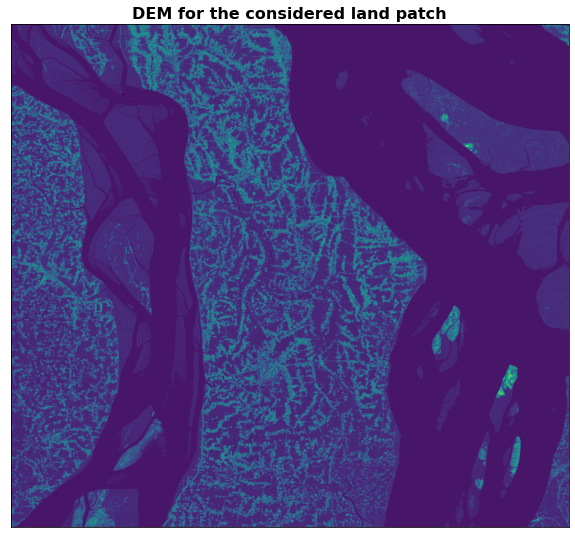

In [5]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(raster.ReadAsArray())
ax.set_title("DEM for the considered land patch", fontsize=16, fontweight="bold")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

We then provide a brief summary of the school coordinates.

In [6]:
schools.info()
schools.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1451 entries, 0 to 1450
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   school  1451 non-null   object 
 1   x       1451 non-null   float64
 2   y       1451 non-null   float64
dtypes: float64(2), object(1)
memory usage: 34.1+ KB


,school,x,y
1408,KUTUBGONJ HIGH SCHOOL,90.758510,22.166078
472,Serampore Union Institution,88.344894,22.754535
291,Gojmahal Tannery High School,90.365413,23.735513
1190,Nabadwip Hindu School,88.365048,23.411553
969,28 No Calitabunia Bazar Primary School Cycole ...,89.828906,22.225340


### Definition of process methods

In this section, we will implement all the methods involved in the computation process.

In the cell below, we implement the method that we will use to compute the flooded school for every sea level elevation.
This method requires three things:
- The DEM data, provided as a file path.
- The coordinates of the points where the schools are located, expressed in the same referential used by the DEM.
- The sea level elevation.

This model is simplistic. It relies on the simplest possible hypothesis : if a land patch is below the sea level elevation, it is flooded. There is obviously some room to improve this model.

In [7]:
def get_flooded_points(filepath: str, coordinates: pd.DataFrame, sea_level: float) -> pd.DataFrame:
    """
    Computes the subset of the provided coordinates that would be flooded for the provided sea level elevation value.
    
    This method requires the DEM data of the considered land patch. This data should be provided via the file path towards the raster data.
    """
    with rio.open(filepath) as dataset:
        dem = dataset.read(1)
        no_data_flag = dataset.nodata
        
        # define flooded schools
        flooded = []
        levels = []
        for row in coordinates.index:
            longitude, latitude = coordinates.loc[row, "x"], coordinates.loc[row, "y"]
            px, py = dataset.index(longitude, latitude)
            if px >= 0 and py >= 0 and px < dem.shape[0] and py < dem.shape[1]:
                if (dem[px, py] != no_data_flag) and (dem[px, py] <= sea_level):
                    flooded.append(row)
                    levels.append(dem[px, py])
        
        output = coordinates.loc[flooded, :].copy()
        output["sea level"] = levels
        return output

We then define the method that will compute the sea elevation for each year. It computes these from the four parameter values, defined in the parameter section, corresponding to the current and target elevation and year.

Again, this model is simplistic. It linearly interpolates the elevations from the starting and ending values, according to the starting and ending year. There is obviously some room to improve here.

In [8]:
def interpolate_elevations(start_year: int, end_year: int, start_elevation: float, end_elevation: float) -> pd.Series:
    """
    Computes the sea level elevations from a starting and ending values, on a regularly spaced time index defined by its starting and ending values.
    
    This method returns a ``pandas.Series`` that contains the years (i.e. the values of the time index) in its index and the elevations in its values.
    """
    return pd.Series(
        name="sea level elevation",
        index=pd.Index(name="year", data=np.arange(start_year, end_year + 1)),
        data=np.linspace(start_elevation, end_elevation, end_year - start_year + 1)
    )

We illustrate the previous two methods in the following cell, for arbitrary chosen values.

                                     school          x          y  sea level
867               Bauphal Model High school  90.555746  22.418578   3.238195
1373  HAZIRHAT GOVT. MODEL SECONDARY SCHOOL  90.964920  22.257572   3.880302
1374    HAZIRHAT MODEL GOVT. PRIMARY SCHOOL  90.971723  22.261374   4.509351
1412            PURBA OSMANGONJ HIGH SCHOOL  90.745792  22.234518   3.188560
1416         BIBIR HAT RASHIDIA HIGH SCHOOL  90.969048  22.613376   3.564358


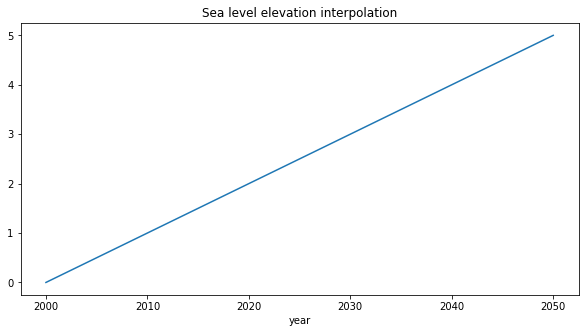

In [9]:
elevation = 5  # sea level elevation

# get flooded schools corresponding to the elevation
flooded_schools = get_flooded_points(
    filepath=DEM_PATH,
    coordinates=schools,
    sea_level=elevation
)
print(flooded_schools)

# elevations per year
elevations = interpolate_elevations(
    start_year=2000,
    end_year=2050,
    start_elevation=0,
    end_elevation=elevation
)
elevations.plot(figsize=(10, 5), title="Sea level elevation interpolation")
plt.show()

## Computations

We now turn to the actual computations of the predicted flooded schools, from the specified parameters in the parameter section and the defined method in the previous section!

In order to to that, we will interpolate the sea level elevations from the provided years and elevations, and compute for each year, and therefore for each elevation level, the flooded schools.

In [10]:
# sea levels
elevations = interpolate_elevations(
    start_year=CURRENT_YEAR,
    end_year=TARGET_YEAR,
    start_elevation=CURRENT_ELEVATION,
    end_elevation=TARGET_ELEVATION
)

# compute flooded schools
floods = pd.DataFrame()
for year, elevation in elevations.items():
    print(f"  . computing for year {year}")
    flooded_this_year = get_flooded_points(filepath=DEM_PATH, coordinates=schools, sea_level=elevation)
    flooded_this_year["year"] = year
    flooded_this_year["sea level"] = elevation
    floods = pd.concat((floods, flooded_this_year), axis=0)
floods = floods.groupby("school").agg({"x": "first", "y": "first", "year": "min", "sea level": "min"})

# assign each year to an arbitrary defined date
floods["date"] = floods["year"].apply(lambda x: dt.date(year=x, month=4, day=22))

floods = floods.sort_values(by="date", ascending=True)[["year", "date", "x", "y", "sea level"]] 
floods.info()
floods.head()

  . computing for year 2020
  . computing for year 2021
  . computing for year 2022
  . computing for year 2023
  . computing for year 2024
  . computing for year 2025
  . computing for year 2026
  . computing for year 2027
  . computing for year 2028
  . computing for year 2029
  . computing for year 2030
  . computing for year 2031
  . computing for year 2032
  . computing for year 2033
  . computing for year 2034
  . computing for year 2035
  . computing for year 2036
  . computing for year 2037
  . computing for year 2038
  . computing for year 2039
  . computing for year 2040
  . computing for year 2041
  . computing for year 2042
  . computing for year 2043
  . computing for year 2044
  . computing for year 2045
  . computing for year 2046
  . computing for year 2047
  . computing for year 2048
  . computing for year 2049
  . computing for year 2050
<class 'pandas.core.frame.DataFrame'>
Index: 14 entries, Bauphal Model High school to Bauphal daspara model primary school
Data colu

,year,date,x,y,sea level
school,,,,,
Bauphal Model High school,2030,2030-04-22,90.555746,22.418578,3.333333
PURBA OSMANGONJ HIGH SCHOOL,2030,2030-04-22,90.745792,22.234518,3.333333
BIBIR HAT RASHIDIA HIGH SCHOOL,2031,2031-04-22,90.969048,22.613376,3.666667
HAZIRHAT GOVT. MODEL SECONDARY SCHOOL,2032,2032-04-22,90.964920,22.257572,4.000000
HAZIRHAT MODEL GOVT. PRIMARY SCHOOL,2034,2034-04-22,90.971723,22.261374,4.666667


Once this is done, we can export the data to the output folder.

In [11]:
floods.to_csv(join(OUTPUT_FOLDER, "school_flood_by_year.csv"), sep=",", header=True, index=True)

## Visualizations

Now that we have our data, it is time to produce beautiful visualizations !

First, we group the schools by year and count how many schools are flooded each year. We plot this in a bar diagram.

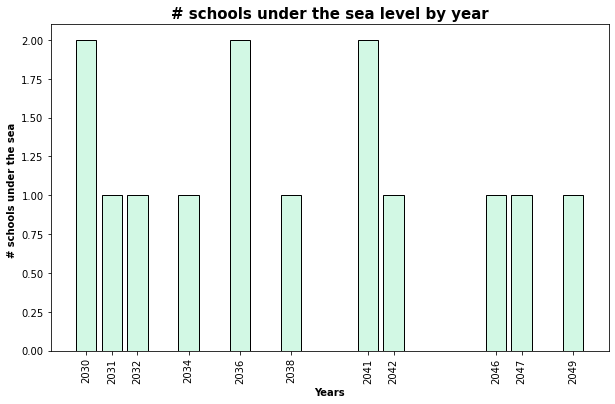

In [12]:
flood_counts = (
    floods
    .reset_index()
    .groupby(by="year")
    .agg({"school": "count"})
    .rename(columns={"school": "# schools"})
    .reset_index()
)

# Axis definition: x are years and y the number of schools under the sea
x = flood_counts['year'] 
y = flood_counts['# schools']
n_bins = 19

# Creating histogram
plt.figure(figsize=(10, 6))

# Bar Construction
plt.bar(x,
        y,
        align='center' , 
        facecolor='#D2F8E4' , 
        edgecolor = 'black' ) # A bar chart

# X custom Axis
plt.xlabel('Years' , fontweight='bold')
plt.xticks(x, rotation = 90)

# Y custom Axis
plt.ylabel('# schools under the sea ', fontweight='bold')

# Title custom
plt.title('# schools under the sea level by year', fontweight='bold', size=15)

# Export & show
plt.savefig(join(OUTPUT_FOLDER, "school_flooded_by_year.png"))
plt.show()